In [156]:
import os
import numpy as np
import cv2
import mediapy as media
import itertools as it
pi2 = np.pi*2

In [157]:
folder = 'parrington'
name = 'prtn'

In [158]:
img_name = [i for i in os.listdir(folder) if name in i]
indices = np.argsort([int(i.split('.')[0][-2:]) for i in img_name])
img_name = np.array(img_name)[indices]
imgs = np.array([media.read_image(f"{folder}/{i}").astype(np.float32)/255 for i in img_name])

gimgs = np.array([cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in  imgs])


In [159]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

## DoG in Scale-Space

In [160]:
SIGMA = 1.6
S = 5
mult = 2**(1/(S-1))
OCTAVE = 4
idx = 5
img = gimgs[idx].copy()
show = imgs[idx].copy()
# img = cv2.rotate(gimgs[idx], cv2.ROTATE_90_CLOCKWISE)
# show = cv2.rotate(imgs[idx], cv2.ROTATE_90_CLOCKWISE)
# img = rotate_image(img, 45)
# show = rotate_image(show, 45)

In [161]:
def normalize(img):
    min = img.min()
    ret = img.copy() - min
    ret /= ret.max()
    return ret
scale_imgs = []
gs_imgs = []
sigmas = []
tar = cv2.GaussianBlur(img, (3, 3), SIGMA*.5)
# tar = img.copy()
for o in range(OCTAVE):
    sigma = SIGMA * (2**o)
    gs_img = []
    for s in range(S):
        sigmas.append(sigma)
        gs_img.append(cv2.GaussianBlur(tar, (3, 3), sigma))
        sigma *= mult
    dog = np.diff(gs_img, axis=0)
    scale_imgs.append([normalize(i) for i in dog])
    gs_imgs.append(gs_img)
    tar = cv2.resize(tar, (tar.shape[1]//2, tar.shape[0]//2))
sigmas = np.array(sigmas).reshape(OCTAVE, S).astype(np.float32)


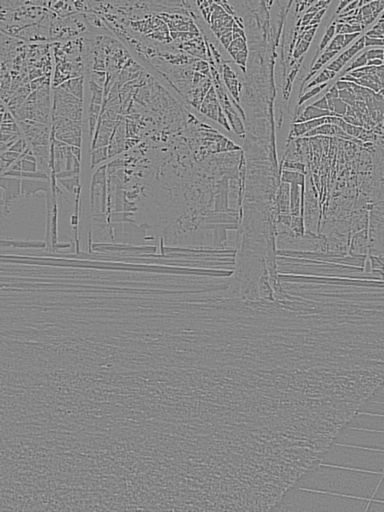
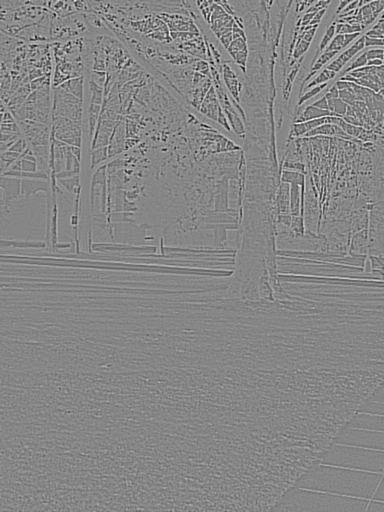
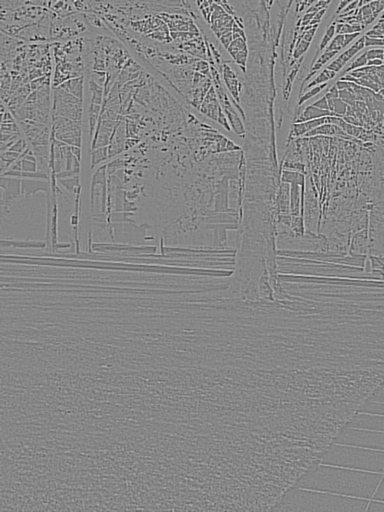
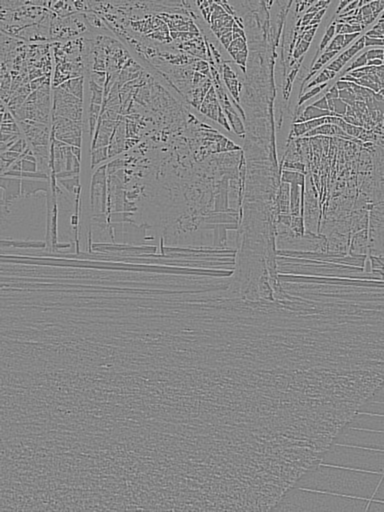


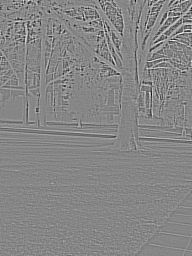
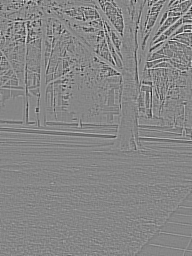
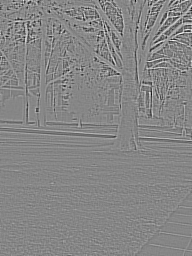
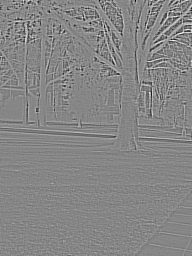


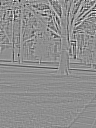
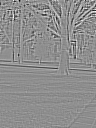
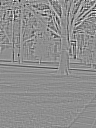
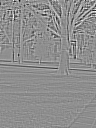


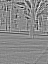
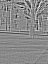
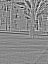
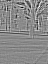

In [162]:
for i in range(OCTAVE):
    media.show_images(scale_imgs[i])

## Key Localization (extrema)

In [163]:
def computeGradient(blk):
    dx = 0.5*(blk[:, 2, 1, 1] - blk[:, 0, 1, 1])
    dy = 0.5*(blk[:, 1, 2, 1] - blk[:, 1, 0, 1])
    dz = 0.5*(blk[:, 1, 1, 2] - blk[:, 1, 1, 0])
    grad = np.transpose([dx, dy, dz], (1, 0))
    return grad

def computeHessian(blk):
    pix = blk[:, 1, 1, 1]
    dxx = blk[:, 2, 1, 1] - 2 * pix + blk[:, 0, 1, 1]
    dyy = blk[:, 1, 2, 1] - 2 * pix + blk[:, 1, 0, 1]
    dzz = blk[:, 1, 1, 2] - 2 * pix + blk[:, 1, 1, 0]
    dxy = 0.25 * (blk[:, 2, 2, 1] - blk[:, 2, 0, 1] - blk[:, 0, 2, 1] + blk[:, 0, 0, 1])
    dxz = 0.25 * (blk[:, 2, 1, 2] - blk[:, 2, 1, 0] - blk[:, 0, 1, 2] + blk[:, 0, 1, 0])
    dyz = 0.25 * (blk[:, 1, 2, 2] - blk[:, 1, 2, 0] - blk[:, 1, 0, 2] + blk[:, 1, 0, 0])
    hess = np.array([
        [dxx, dxy, dxz], 
        [dxy, dyy, dyz],
        [dxz, dyz, dzz]]).transpose(2, 0, 1)
    return hess

In [164]:
def detectExterema(simgs, threshold=0.6):
    simgs = np.array(simgs)
    h, w = simgs[0].shape
    slwds = np.lib.stride_tricks.sliding_window_view(simgs, (3, 3, 3))
    ids = []
    ids_orig = []
    for idx_img, slwd in enumerate(slwds):
        slwd_flat = slwd.reshape(*slwd.shape[:2], -1)
        # (1, 1, 1) == np.unravel_index(13, (3, 3, 3))
        # That is, the center has index 13 in a 3x3x3 block
        select = slwd_flat.argmax(2) == 13
        if np.sum(select) == 0:
            continue
        # print(slwd.shape)
        # print(maxs.shape)
        # (..., scale, h, w)
        blk = slwd[select]
        # print(blk.shape)
        
        # Gradient
        grad = computeGradient(blk)
        # print(grad.shape)
        
        # Hessian
        hess = computeHessian(blk)
        # print(hess.shape)

        # Fix exterema position
        idx_fixed = -np.matmul(np.linalg.inv(hess), grad.reshape(grad.shape[0], 3, 1)).squeeze()
        idx_fix_orig = idx_fixed.copy()

        sel_pos = idx_fixed>.5
        sel_neg = idx_fixed<-.5
        idx_fixed[sel_pos] = 1
        idx_fixed[sel_neg] = -1
        idx_fixed[~(sel_pos|sel_neg)] = 0
        idx_fixed = idx_fixed
        
        idx = np.argwhere(select)+1
        idx = np.concatenate([np.full((len(idx), 1), idx_img), idx], 1)
        # print(idx.shape)
        idx_fixed = (idx_fixed+idx).astype(int)
        # print(idx_fixed)
        
        # Remove low contrast
        val = simgs[idx_img:idx_img+3][tuple(zip(*idx_fixed))] + 0.5*(grad*idx_fix_orig).sum(1)
        sel_low = val > threshold

        # Remove edges
        H = hess[:, 1:, 1:]
        tr = np.trace(H, axis1=1, axis2=2)
        det = np.linalg.det(H)
        sel_edge = (tr**2 / det) < 12.1

        print(f"Edge: {np.sum(~sel_edge)}, Low contrast: {np.sum(~sel_low)}, Total: {sel_low.shape}")
        select = (sel_edge&sel_low)

        print(f"Remove {(~select).sum()} points")
        ids += idx_fixed[select].tolist()
        ids_orig += (idx_fix_orig+idx)[select].tolist()

    return np.array(ids).astype(int), np.array(ids_orig)

In [165]:
ids = []
ids_orig = []
for o in range(OCTAVE):
    oids, oids_orig = np.array(detectExterema(scale_imgs[o]))
    if len(oids) == 0:
        print(f"Skip {o+1}")
        ids.append([])
        ids_orig.append([])
        continue
    # octave, sigma(idx), h, w
    oids = np.concatenate([np.full((oids.shape[0], 1), o), oids], 1)
    oids_orig = np.concatenate([np.full((oids_orig.shape[0], 1), o), oids_orig], 1)
    ids.append(oids)
    ids_orig.append(oids_orig)
    print(f"Octave {o+1}: {len(oids)}")
ids = np.concatenate(ids, axis=0).astype(int)
ids_orig = np.concatenate(ids_orig, axis=0)


Edge: 2, Low contrast: 2, Total: (7,)
Remove 3 points
Edge: 1, Low contrast: 0, Total: (15,)
Remove 1 points
Octave 1: 18
Edge: 11, Low contrast: 32, Total: (145,)
Remove 40 points
Edge: 1, Low contrast: 1, Total: (21,)
Remove 2 points
Octave 2: 124
Edge: 17, Low contrast: 97, Total: (314,)
Remove 109 points
Edge: 0, Low contrast: 2, Total: (7,)
Remove 2 points
Octave 3: 210
Edge: 16, Low contrast: 38, Total: (101,)
Remove 50 points
Edge: 6, Low contrast: 26, Total: (63,)
Remove 30 points
Octave 4: 84



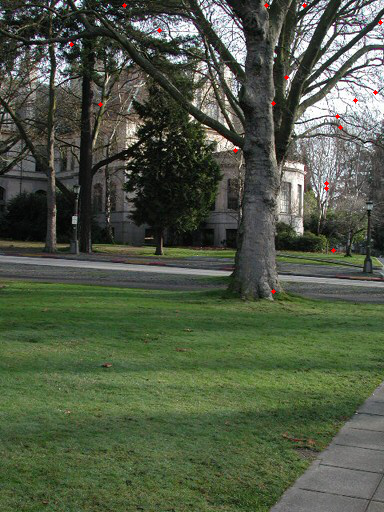


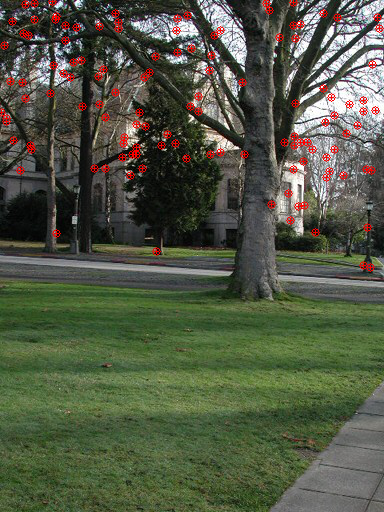


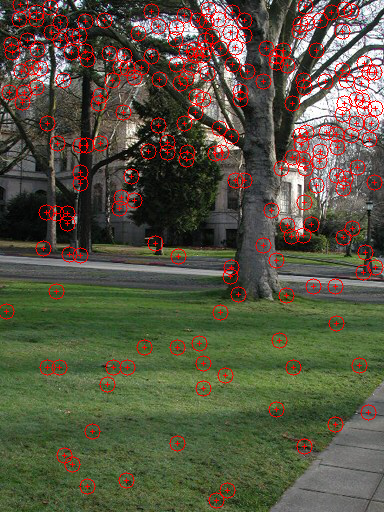


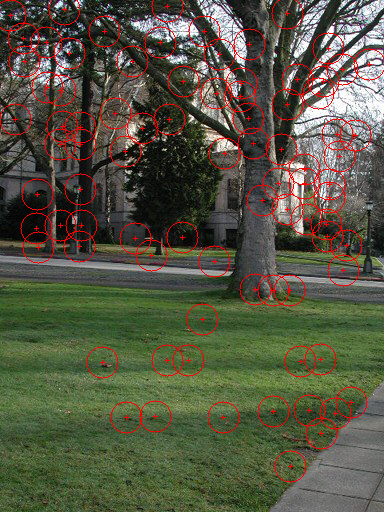

In [166]:
for o in range(OCTAVE):
    p = show.copy()
    id = ids_orig[ids_orig[:, 0]==o]
    # print(id)
    if len(id) == 0:
        continue
    for o, s, i, j in id:
        # color = (255, 255//s ,255//s)
        color = (255, 0 ,0)
        ii, jj = int(i*2**o), int(j*2**o)
        cv2.drawMarker(p, (jj, ii), color, markerSize=5)
        cv2.circle(p, (jj, ii), int(2*2**o), color, 1)
    media.show_image(p)
    # media.show_image(cv2.rotate(p, cv2.ROTATE_90_COUNTERCLOCKWISE))
    # media.show_image(rotate_image(p, -30))

    

## Orientation Assignment

In [167]:
# g = np.array(gs_imgs, dtype=object)
# gs_imgs[[0, 1]]
half_width = 8
cell_width = half_width*2
k = np.array([[-1, 0, 1]])
mags = []
angs = []
dxs = []
dys = []
for gs_imgs_octave in gs_imgs:
    mag = []
    ang = []
    dxx = []
    dyy = []
    for gs_img in gs_imgs_octave[:-1]:
        dx = (cv2.filter2D(gs_img, -1, k, ))
        dy = (cv2.filter2D(gs_img, -1, k.T))
        dxx.append(dx)
        dyy.append(dy)
        ang_ = cv2.copyMakeBorder(np.arctan2(dx, dy), half_width, half_width-1, half_width, half_width-1, cv2.BORDER_REFLECT)
        ang_[ang_<0] += pi2
        ang.append(ang_)
        mag.append(cv2.copyMakeBorder(np.sqrt(dx**2+dy**2), half_width, half_width-1, half_width, half_width-1, cv2.BORDER_REFLECT))
        # mag.append(np.sqrt(dx**2+dy**2))
        # ang.append(np.arctan2(dx, dy)+np.pi) # dx is vertical
    angs.append(ang)
    mags.append(mag)
    dxs.append(dxx)
    dys.append(dyy)

In [168]:
cells_mag = []
cells_ang = []
for o, s, i, j in ids:
    cells_mag.append(mags[o][s][i:i+cell_width, j:j+cell_width])
    cells_ang.append(angs[o][s][i:i+cell_width, j:j+cell_width])

In [169]:
# k = cv2.getGaussianKernel(3, )
weight = [[cv2.getGaussianKernel(cell_width, 1.*s) for s in ss] for ss in sigmas]
weight = [[w@w.T for w in ww] for ww in weight]

In [170]:
# TODO
# (OK) find orient
# use the orient to resample the mag and ang
    # make center of grid 0 by sub from (w-1)/2
    # rotate -orient around center (0)
    # resample the cells_mag and cells_ang by rotated coord
    #       - the up-dir of cell is tilted -> the cell is a tilted square in the image
def sampleRotatedCell(o, s, pi, pj, orient, mag, ang, w=16):
    offset = (w*0.5-0.5)
    a = np.arange(0, w)-offset
    y, x = np.meshgrid(a, a)
    theta = -ang
    sin  = np.sin(theta)
    cos  = np.cos(theta)
    xx = x*cos-y*sin
    yy = x*sin+y*cos

    yy = np.clip(np.round(pi+yy).astype(int)+w, 0, mag.shape[0])
    xx = np.clip(np.round(pj+xx).astype(int)+w, 0, mag.shape[1])
    # tuple(zip(*yy, xx))
    mag = mags[o][s][(yy, xx)]
    ang = np.fmod(angs[o][s][(yy, xx)]-theta, pi2)
    # print(mag.shape, ang.shape)
    return mag, ang



In [171]:
new_cells_ang = []
new_cells_mag = []
new_ids = [] # mapped from ids
orients = []
# mags = []
bin = np.histogram_bin_edges([], bins=36, range=(0, pi2))
bin = (bin[:-1]+bin[1:])*.5
for i, (o, s, pnti, pntj) in enumerate(ids):
    hist = np.histogram(cells_ang[i], bins=36, range=(0, pi2), weights=cells_mag[i]*weight[o][s])[0]
    max_id = np.argmax(hist)
    near_peak = (hist > 0.8*hist[max_id])
    num_near_peak = near_peak.sum()
    if num_near_peak > 2:
        # abort
        continue
    elif num_near_peak == 1:
        # 1 peak
        orient = bin[max_id]
        mag, ang = sampleRotatedCell(o, s, pnti, pntj, orient, cells_mag[i], cells_ang[i])
        new_cells_ang.append(ang)
        new_cells_mag.append(mag)

        new_ids.append(i)
        orients.append(orient)
        # mags.append(hist[max_id])
    else:
        # 2 peaks
        peak_id = np.argwhere(near_peak)
        
        orient = bin[peak_id[0]]

        mag, ang = sampleRotatedCell(o, s, pnti, pntj, orient, cells_mag[i], cells_ang[i])
        new_cells_ang.append(ang)
        new_cells_mag.append(mag)

        orients.append(orient)
        # mags.append(hist[peak_id[0]])

        orient = bin[peak_id[1]]
        mag, ang = sampleRotatedCell(o, s, pnti, pntj, orient, cells_mag[i], cells_ang[i])
        new_cells_ang.append(ang)
        new_cells_mag.append(mag)
        orients.append(orient)
        # mags.append(hist[peak_id[1]])

        new_ids += [i, i]

new_cells_mag = np.array(new_cells_mag)
new_cells_ang = np.array(new_cells_ang)
new_ids_orig = ids_orig[new_ids]
new_ids = ids[new_ids]


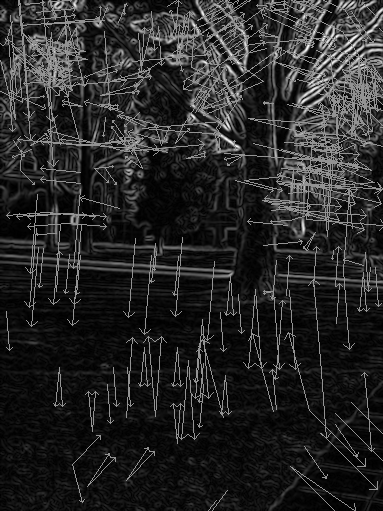

In [172]:
show_ = mags[0][0][8:-8, 8:-8].copy()
# show_ = show.copy()
for idx, (o, s, i, j) in enumerate(new_ids_orig):
    j = int(j*2**o)
    i = int(i*2**o)
    # if o > 1:
    #     continue
    p1 = (j, i)
    ang = -orients[idx]
    mag = 10 *2**o
    c = mag*np.cos(ang)
    s = mag*np.sin(ang)
    p2 = (int(j - s), int(i + c))
    cv2.arrowedLine(show_, p1, p2, (.3, 0, 0), thickness=1)
media.show_image(show_)


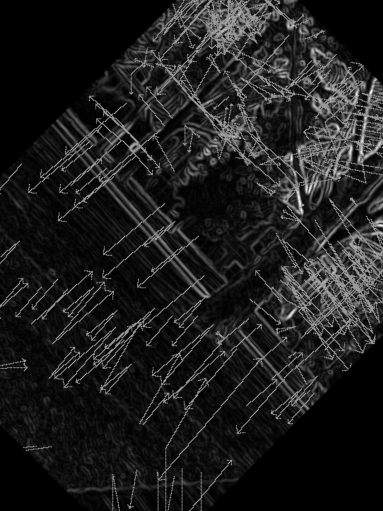

In [173]:
# media.show_image(cv2.rotate(show_, cv2.ROTATE_90_COUNTERCLOCKWISE))
media.show_image(rotate_image(show_, -45))


## Local Image Descriptor

In [174]:
weight = [[cv2.getGaussianKernel(16, .5*s) for s in ss] for ss in sigmas]
weight = [[w@w.T for w in ww] for ww in weight]
weighted_new_cells_mag = []
for i, (o, s, _, _) in enumerate(new_ids):
    weighted_new_cells_mag.append(new_cells_mag[i]*weight[o][s])
weighted_new_cells_mag = np.array(weighted_new_cells_mag)


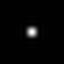
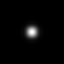
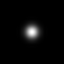
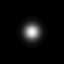
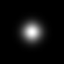


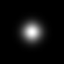
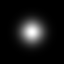
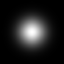
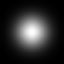
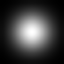


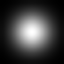
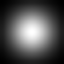
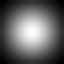
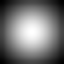
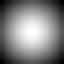


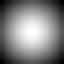
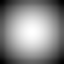
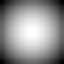
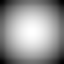
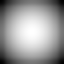

In [175]:
for ww in weight:
    w = media.resize_video(ww, (64, 64))
    media.show_images(w)

In [201]:
desc = [np.histogram(ang, bins=8, range=(0, pi2), density=True, weights=mag)[0]
    for ang, mag in zip(*[
        new_cells_ang.reshape(-1, 4, 4, 4, 4).swapaxes(2, 3).reshape(-1, 16),
        weighted_new_cells_mag.reshape(-1, 4, 4, 4, 4).swapaxes(2, 3).reshape(-1, 16)])]
desc = np.array(desc)
desc[desc>.2] = .2
desc = (desc/np.linalg.norm(desc, ord=2, axis=1, keepdims=True)).reshape(-1, 128)

[[0.00000000e+00 1.02070967e-02 2.21349340e-03 ... 0.00000000e+00
  3.91984844e-01 8.56273735e-01]
 [1.91008555e-03 1.14617279e-02 3.84228948e-05 ... 0.00000000e+00
  2.24460307e-01 4.92233576e-01]
 [3.07728991e-04 4.77551787e-04 1.36485438e-02 ... 0.00000000e+00
  0.00000000e+00 2.38402272e-01]
 ...
 [9.44902239e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 3.28337146e-01]
 [6.38714915e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 6.34524353e-01]
 [0.00000000e+00 1.82478733e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


## Final Descriptor Merge

In [198]:
i

496